In [24]:
import joblib
from scipy.stats import rankdata
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from scipy.stats import pearsonr
import sys
import matplotlib.pyplot as plt

sys.path.append("../src")
from model import OnTheFlyModel, precalc_embeddings_reference, precalc_embeddings

hits, fid_prom, pid_prom = joblib.load(os.path.join("..", "data", "hits.joblib"))
fids, _, _ = joblib.load(os.path.join("..", "data", "cemm_emb.joblib"))
G = joblib.load("../graph_proteins.joblib")

proteome_reference_predictions_file = "../data/proteome_reference_predictions_07.joblib"

if not os.path.exists(proteome_reference_predictions_file):

    protein_precalcs_baseline = joblib.load("../data/protein_precalcs_baseline.joblib")

    proteome_reference_predictions = []
    for r in protein_precalcs_baseline:
        auroc = r["auroc"][0]
        if auroc is None:
            continue
        if auroc < 0.7:
            continue
        proteome_reference_predictions += [r["y_hat_ref"]]
    proteome_reference_predictions = np.array(proteome_reference_predictions).T

    joblib.dump(proteome_reference_predictions, proteome_reference_predictions_file)

else:
    proteome_reference_predictions = joblib.load(proteome_reference_predictions_file)


uniprot_acs = [n for n in G.nodes()]


class HitSelector(object):
    def __init__(self, uniprot_acs):
        self._valid_prots = set(pid_prom.keys())
        self.uniprot_acs = [pid for pid in uniprot_acs if pid in self._valid_prots]
        self.fids = fids
        self.pids = self.uniprot_acs
        self._fid_prom = []
        for fid in self.fids:
            if fid in fid_prom:
                self._fid_prom += [fid_prom[fid]]
            else:
                self._fid_prom += [0]

    def select(self, min_prop_hit_proteins=0, max_hit_fragments=100):
        min_hit_proteins = int(min_prop_hit_proteins * len(self.uniprot_acs))
        my_hits_dict = collections.defaultdict(int)
        pids_set = set(self.uniprot_acs)
        for k, _ in hits.items():
            if k[0] in pids_set:
                my_hits_dict[k[1]] += 1
        my_hits = []
        for fid in self.fids:
            if fid in my_hits_dict:
                my_hits += [my_hits_dict[fid]]
            else:
                my_hits += [0]
        y = []
        for h in my_hits:
            if h == 0:
                y += [0]
            else:
                if h >= min_hit_proteins:
                    y += [1]
                else:
                    y += [0]
        data = {"fid": self.fids, "prom": self._fid_prom, "hits": my_hits, "y": y}
        if np.sum(data["y"]) > max_hit_fragments:
            promiscuity_ranks = rankdata(data["prom"], method="ordinal")
            promiscuity_ranks = promiscuity_ranks / np.max(promiscuity_ranks)
            data_ = pd.DataFrame(data)
            data_["ranks"] = promiscuity_ranks
            data_ = data_.sort_values(by="ranks", ascending=True)
            data_1 = data_[data_["y"] == 1]
            data_1 = data_1.head(max_hit_fragments)
            fids_1 = set(data_1["fid"])
            y = []
            for fid in data["fid"]:
                if fid in fids_1:
                    y += [1]
                else:
                    y += [0]
            data["y"] = y
        data = pd.DataFrame(data)
        return data
    

class HitSelectorByOverlap(object):
    def __init__(self, uniprot_acs, tfidf):
        self._valid_prots = set(pid_prom.keys())
        self.uniprot_acs = [pid for pid in uniprot_acs if pid in self._valid_prots]
        self.fids = fids
        self.pids = self.uniprot_acs
        self._fid_prom = []
        for fid in self.fids:
            if fid in fid_prom:
                self._fid_prom += [fid_prom[fid]]
            else:
                self._fid_prom += [0]
        self.tfidf = tfidf
        self.fid2pid = collections.defaultdict(list)
        for k,v in hits.items():
            self.fid2pid[k[1]] += [(k[0], v)]

    def select_without_tfidf(self, max_hit_fragments, max_fragment_promiscuity):
        protein_overlaps = []
        my_hits = []
        for i, fid in enumerate(self.fids):
            prom = self._fid_prom[i]
            if prom > max_fragment_promiscuity:
                my_hits += [-1]
                protein_overlaps += [-1]
            else:
                if fid in self.fid2pid:
                    all_prots = [x[0] for x in self.fid2pid[fid]]
                    sel_prots = list(set(self.uniprot_acs).intersection(all_prots))
                    my_hits += [len(sel_prots)]
                    protein_overlaps += [len(sel_prots)/len(all_prots)]
                else:
                    my_hits += [0]
                    protein_overlaps += [0]
        y = [0]*len(fids)
        idxs = np.argsort(protein_overlaps)[::-1]
        idxs = idxs[:max_hit_fragments]
        for idx in idxs:
            if protein_overlaps[idx] == 0:
                continue
            y[idx] = 1
        y = np.array(y)
        protein_overlaps = np.array(protein_overlaps)
        y[protein_overlaps == -1] = -1
        data = {"fid": self.fids, "prom": self._fid_prom, "hits": my_hits, "y": list(y)}
        return pd.DataFrame(data)

    def select_with_tfidf(self, max_hit_fragments, max_fragment_promiscuity):
        corpus = []
        my_hits = []
        for i, fid in enumerate(self.fids):
            prom = self._fid_prom[i]
            if prom > max_fragment_promiscuity:
                my_hits += [-1]
                corpus += [""]
            else:
                if fid in self.fid2pid:
                    all_prots = [x[0] for x in self.fid2pid[fid]]
                    sel_prots = list(set(self.uniprot_acs).intersection(all_prots))
                    my_hits += [len(sel_prots)]
                    corpus += [" ".join([x[0] for x in self.fid2pid[fid] for _ in range(int(x[1]))])]
                else:
                    my_hits += [0]
                    corpus += [""]
        vectorizer = TfidfVectorizer(min_df=1, lowercase=False)
        tfidf_matrix = vectorizer.fit_transform(corpus).toarray()
        feature_names = vectorizer.get_feature_names_out()
        idxs = []
        for i, n in enumerate(feature_names):
            if n in self.uniprot_acs:
                idxs += [i]
        all_vals = np.sum(tfidf_matrix, axis=1)
        sel_vals = np.sum(tfidf_matrix[:,idxs], axis=1)
        prop_vals = []
        for s, a in zip(sel_vals, all_vals):
            if a == 0:
                prop_vals += [0]
            else:
                prop_vals += [s/a]
        y = [0]*len(fids)
        idxs = np.argsort(prop_vals)[::-1]
        idxs = idxs[:max_hit_fragments]
        for idx in idxs:
            if prop_vals[idx] == 0:
                continue
            y[idx] = 1
        y = np.array(y)
        my_hits = np.array(my_hits)
        y[my_hits == -1] = -1
        data = {"fid": self.fids, "prom": self._fid_prom, "hits": list(my_hits), "y": list(y)}
        return pd.DataFrame(data)

    def select(self, max_hit_fragments, max_fragment_promiscuity):
        if self.tfidf:
            return self.select_with_tfidf(max_hit_fragments=max_hit_fragments, max_fragment_promiscuity=max_fragment_promiscuity)
        else:
            return self.select_without_tfidf(max_hit_fragments=max_hit_fragments, max_fragment_promiscuity=max_fragment_promiscuity)
        

model = OnTheFlyModel()

def screen_max_hit_fragments(uniprot_acs, tfidf):
    cuts = [int(x) for x in np.arange(10, 210, 10)]
    aurocs = []
    proms = []
    hits = []
    ref_rhos = []
    for n in tqdm(cuts):
        data = HitSelectorByOverlap(uniprot_acs, tfidf=tfidf).select(n)
        model.baseline_classifier.fit(precalc_embeddings, data["y"])
        y_hat_ref = np.array(model.baseline_classifier.predict_proba(precalc_embeddings_reference)[:,1])
        rho = np.nanmean([pearsonr(y_hat_ref, proteome_reference_predictions[:,j])[0] for j in range(proteome_reference_predictions.shape[1])])
        auroc = model.estimate_performance(data["y"], baseline=True, n_splits=10)
        aurocs += [auroc[0]]
        proms += [np.mean(data[data["y"] == 1]["prom"])]
        hits += [np.mean(data[data["y"] == 1]["hits"])]
        ref_rhos += [rho]
    return pd.DataFrame({"hit_cut": cuts, "auroc": aurocs, "prom": proms, "hits": hits, "ref_rho": ref_rhos})


def evaluate_predictive_capacity(uniprot_acs, tfidf):
    prom_cuts = []
    hit_cuts = []
    aurocs = []
    n_pos = []
    n_tot = []
    for prom_cut in [50, 100, 250, 500]:
        for hit_cut in [10, 50, 100, 200]:
            prom_cuts += [prom_cut]
            hit_cuts += [hit_cut]
            data = HitSelectorByOverlap(uniprot_acs=uniprot_acs, tfidf=tfidf).select(hit_cut, prom_cut)
            n_pos += [len(data[data["y"] == 1])]
            n_tot += [len(data[data["y"] != -1])]
            auroc = model.estimate_performance(data["y"], baseline=True, n_splits=10)
            aurocs += [auroc[0]]
    data = {"hit_cut": hit_cuts, "prom_cut": prom_cuts, "n_pos": n_pos, "n_tot": n_tot, "auroc": aurocs}
    return pd.DataFrame(data)


def evaluate_predictive_capacity_aggregate(uniprot_acs, tfidf):
    res = evaluate_predictive_capacity(uniprot_acs=uniprot_acs, tfidf=tfidf)
    aurocs = []
    for auroc in list(res["auroc"]):
        if str(auroc) == "nan":
            aurocs += [0.5]
        else:
            aurocs += [float(auroc)]
    return np.percentile(aurocs, 90)


d = HitSelectorByOverlap(uniprot_acs=uniprot_acs, tfidf=True).select(10, 200)

evaluate_predictive_capacity_aggregate(uniprot_acs, True)


0.6771139705882352

In [25]:
import community as community_louvain

partition = community_louvain.best_partition(G)


In [29]:
def community_subgraphs(G):
    partition = community_louvain.best_partition(G)
    clusters = collections.defaultdict(list)
    for k, v in partition.items():
        clusters[v] += [k]
    clusters = [tuple(sorted(v)) for k, v in clusters.items()]
    clusters = set(clusters)
    clusters = sorted(clusters, key=lambda x: -len(x))
    subgraphs = []
    for nodes in clusters:
        subgraphs += [G.subgraph(list(nodes)).copy()]
    return subgraphs

subgraphs = community_subgraphs(G)

In [36]:
def accept_graph(G):
    uniprot_acs = G.nodes()
    if len(uniprot_acs) == 1:
        return True
    auroc = evaluate_predictive_capacity_aggregate(uniprot_acs, True)
    if auroc > 0.7:
        return True
    return False


for subgraph in subgraphs:
    print(accept_graph(subgraph))

False
True
False
False
True


In [38]:
accept_graph(G)

False

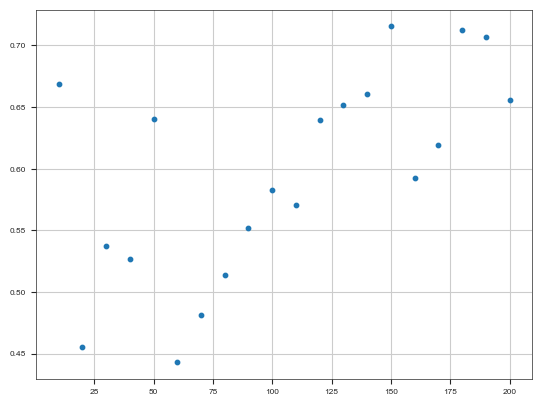

In [109]:
plt.scatter(res["cut"], res["auroc"])

In [56]:
from scipy.interpolate import UnivariateSpline

spline = UnivariateSpline(x, y)

,cut,auroc
0,10,0.506250
1,20,0.724359
2,30,0.790022
3,40,0.801520
4,50,0.801520
5,60,0.801520
6,70,0.801520
7,80,0.801520
8,90,0.801520
9,100,0.801520


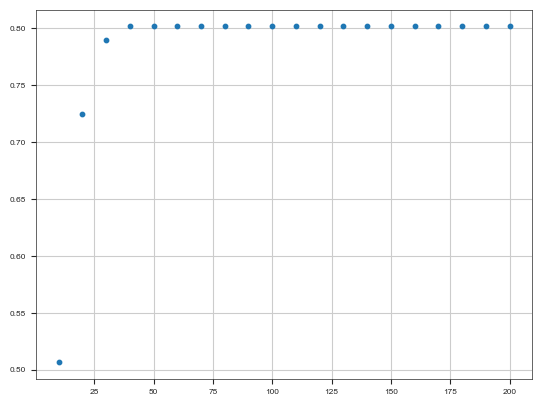

In [55]:
plt.scatter(data["cut"], data["auroc"])

In [45]:
np.arange(10, 210, 10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])

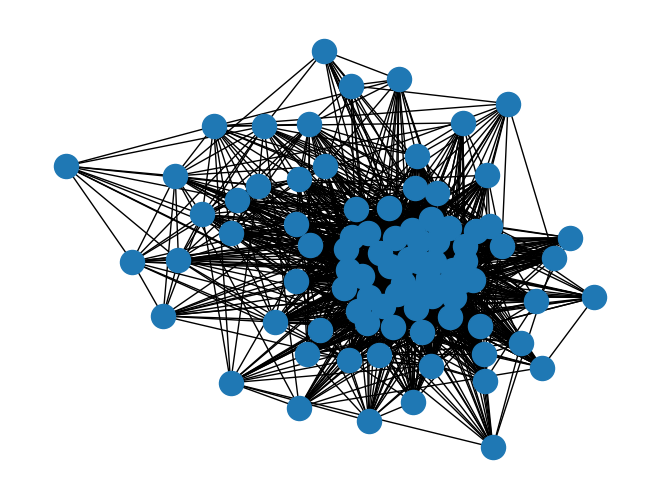

In [12]:
import networkx as nx

nx.draw(G)

In [1]:
import joblib
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stylia

DATA_PATH = "../data"


In [3]:
result = joblib.load("../data/protein_precalcs_only_aucs.joblib")
x = []
y = []
n_pos = []
for r in result:
    if r["auroc"][0] is not None:
        x += [r["auroc_baseline"][0]]
        y += [r["auroc"][0]]
        n_pos += [r["n_pos"]]
x = np.array(x)
y = np.array(y)
n_pos = np.array(n_pos)

In [32]:
len(x)

64

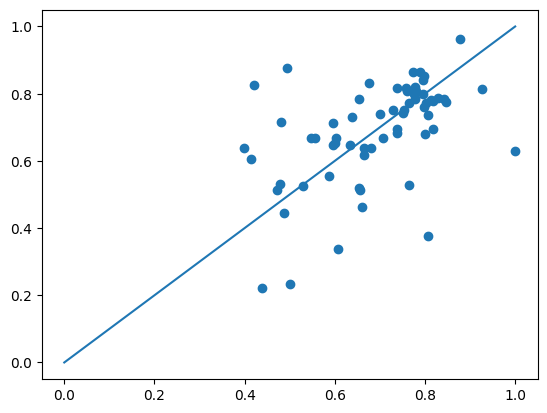

In [33]:
plt.scatter(x,y)
plt.plot([0,1], [0,1])

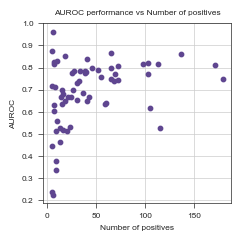

In [9]:
fig, axs = stylia.create_figure(1,1, width=stylia.TWO_COLUMNS_WIDTH/3, height=stylia.TWO_COLUMNS_WIDTH/3)
ax = axs.next()
ax.scatter(n_pos, y)
stylia.label(ax=ax, title="AUROC performance vs Number of positives", xlabel="Number of positives", ylabel="AUROC")
stylia.save_figure("../assets/AUROC_vs_positives.png")

In [38]:
np.median(y), np.median(x)

(0.7231562703053931, 0.7328412167542602)

In [52]:
from fragmentembedding import FragmentEmbedder

fe = FragmentEmbedder()
fe.transform(smiles)

/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unp

array([[ 0.4275 , -0.2642 , -0.243  , ..., -0.1736 ,  0.2369 , -0.04938],
       [ 0.856  , -0.2537 ,  0.10284, ...,  0.08325, -0.06152,  0.2607 ],
       [ 1.499  , -0.2734 ,  0.1271 , ..., -0.2732 , -0.1918 , -0.2783 ],
       ...,
       [ 0.86   , -0.2776 ,  0.566  , ..., -0.2686 , -0.091  , -0.1276 ],
       [ 2.246  , -0.2341 , -0.2727 , ...,  0.155  , -0.2479 , -0.03134],
       [ 2.111  , -0.2474 , -0.2783 , ..., -0.2416 ,  0.2769 ,  0.07086]],
      dtype=float16)

In [61]:
fid2smi = pd.read_csv(os.path.join(DATA_PATH, "cemm_smiles.csv"))

fe = FragmentEmbedder()

print(list(fid2smi["smiles"]))

X = fe.transform(list(fid2smi["smiles"]))
print(X)

/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unp

['C#CCCC1(CCC(=O)NC2(CCO)CS(=O)(=O)C2)N=N1', 'C#CCCC1(CCC(=O)NC(C(N)=O)c2ccc3ccccc3c2)N=N1', 'C#CCCC1(CCC(=O)Nc2ccc(-c3cn4cccc(C)c4n3)cc2)N=N1', 'C#CCCC1(CCNC(=O)c2cc(=O)[nH]c(C3CCOCC3)n2)N=N1', 'C#CCCC1(CCNC(=O)CC2CS(=O)(=O)c3ccccc3O2)N=N1', 'C#CCCC1(CCNC(=O)c2c[nH]c(C(C)(C)C)n2)N=N1', 'C#CCCC1(CCNC(=O)CC2(C(F)(F)F)CCC(=O)NC2)N=N1', 'C#CCCC1(CCC(=O)Nc2cc(CCc3ccccc3C)n[nH]2)N=N1', 'C#CCCC1(CCNC(=O)c2c(C(F)(F)F)nc3n2CCCC3)N=N1', 'C#CCCC1(CCNC(=O)c2cc(OC)c3c(c2)OCCO3)N=N1', 'C#CCCC1(CCNC(=O)c2ncsc2S(N)(=O)=O)N=N1', 'C#CCCC1(CCNC(=O)c2ccc(S(=O)(=O)c3ccccc3)s2)N=N1', 'C#CCCC1(CCC(=O)NC(Cc2ccccn2)C2COc3ccccc3O2)N=N1', 'C#CCCC1(CCC(=O)Nc2ccc3c(c2)nc(C)n3C2(CO)CCC2)N=N1', 'C#CCCC1(CCC(=O)N2CCCN(S(=O)(=O)c3ccc(Cl)s3)CC2)N=N1', 'C#CCCC1(CCNC(=O)C2=NN(c3ccc(F)cc3)C(C(N)=O)C2)N=N1', 'C#CCCC1(CCC(=O)N2C[C@H]3CN(C)CC[C@@]3(CO)C2)N=N1', 'C#CCCC1(CCC(=O)NCCS(=O)(=O)N2CCOCC2)N=N1', 'C#CCCC1(CCC(=O)N2CCC3(CC2)OCc2ccncc23)N=N1', 'C#CCCC1(CCC(=O)NC2CCc3cccc4cccc2c34)N=N1', 'C#CCCC1(CCC(=O)Nc2cc(C3CC3)nn2

100%|██████████| 407/407 [00:03<00:00, 119.42it/s]

[[ 0.4275  -0.2642  -0.243   ... -0.1736   0.2369  -0.04938]
 [ 0.856   -0.2537   0.10284 ...  0.08325 -0.06152  0.2607 ]
 [ 1.499   -0.2734   0.1271  ... -0.2732  -0.1918  -0.2783 ]
 ...
 [ 0.86    -0.2776   0.566   ... -0.2686  -0.091   -0.1276 ]
 [ 2.246   -0.2341  -0.2727  ...  0.155   -0.2479  -0.03134]
 [ 2.111   -0.2474  -0.2783  ... -0.2416   0.2769   0.07086]]


In [56]:
X

array([[ 0.4275 , -0.2642 , -0.243  , ..., -0.1736 ,  0.2369 , -0.04938],
       [ 0.856  , -0.2537 ,  0.10284, ...,  0.08325, -0.06152,  0.2607 ],
       [ 1.499  , -0.2734 ,  0.1271 , ..., -0.2732 , -0.1918 , -0.2783 ],
       ...,
       [ 0.86   , -0.2776 ,  0.566  , ..., -0.2686 , -0.091  , -0.1276 ],
       [ 2.246  , -0.2341 , -0.2727 , ...,  0.155  , -0.2479 , -0.03134],
       [ 2.111  , -0.2474 , -0.2783 , ..., -0.2416 ,  0.2769 ,  0.07086]],
      dtype=float16)

In [38]:
%%time

class BinaryBalancer(object):
    def __init__(self, proportion=0.5, n_samples=1000):
        self.proportion = proportion
        self.n_samples = n_samples

    def _resample(self, X, size, weights):
        idxs = [i for i in range(X.shape[0])]
        sampled_idxs = np.random.choice(idxs, size=(size - X.shape[0]), replace=True, p=weights)
        X_s = X[sampled_idxs]
        nn = NearestNeighbors(n_neighbors=4)
        nn.fit(X)
        neighs = nn.kneighbors(X_s, return_distance=False)[:, 1:]
        R = []
        w = np.array([0.75, 0.5, 0.25])
        w /= w.sum()
        for i in range(X_s.shape[0]):
            gap = random.random()
            j = int(np.random.choice([0, 1, 2], p=w))
            neigh_idx = neighs[i,j]
            d = X[neigh_idx] - X_s[i]
            R += [X_s[i] + gap*d]
        X_s = np.array(R)
        X = np.vstack([X, X_s])
        return X

    def transform(self, X, y, sample_weights=None):
        X = np.array(X)
        y = np.array(y)
        X_0 = X[y == 0]
        X_1 = X[y == 1]
        num_0_samples = int(self.n_samples*(1 - self.proportion))
        num_1_samples = int(self.n_samples*self.proportion)
        if sample_weights is None:
            sample_weights = np.array([1.]*X.shape[0])
        else:
            sample_weights = np.array(sample_weights)
        weights_0 = sample_weights[y == 0]
        weights_1 = sample_weights[y == 1]
        weights_0 = weights_0 / weights_0.sum()
        weights_1 = weights_1 / weights_1.sum()
        X_0 = self._resample(X_0, num_0_samples, weights_0)
        X_1 = self._resample(X_1, num_1_samples, weights_1)
        X = np.vstack([X_0, X_1])
        y = np.array([1]*X_0.shape[0] + [0]*X_1.shape[0])
        idxs = [i for i in range(len(y))]
        random.shuffle(idxs)
        X = X[idxs]
        y = y[idxs]
        return X, y
    
balancer = BinaryBalancer(0.5)
balancer.transform(X, y)

CPU times: user 85.1 ms, sys: 70.4 ms, total: 156 ms
Wall time: 20.5 ms


(array([[-0.2367 ,  3.15   ,  0.332  , ...,  1.206  ,  1.879  ,  0.671  ],
        [-0.2708 ,  0.9556 , -0.1537 , ...,  0.7373 ,  2.055  ,  0.7256 ],
        [ 2.084  , -0.02942, -0.2305 , ...,  1.061  , -0.11847,  1.535  ],
        ...,
        [ 3.053  ,  0.12256, -0.268  , ...,  0.4453 ,  0.01611,  0.6475 ],
        [-0.1337 ,  0.0523 ,  1.02   , ..., -0.1951 ,  0.5938 , -0.1895 ],
        [ 0.6416 , -0.2424 ,  0.03955, ...,  0.602  , -0.2583 ,  1.117  ]],
       dtype=float16),
 array([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0

In [42]:
from fragmentembedding import FragmentEmbedder

fe = FragmentEmbedder()
fe.transform(fids)

/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unp

array([[ 1.4619e+00, -2.7173e-01, -2.3633e-01, -6.2256e-03, -2.4561e-01,
        -1.6663e-01,  6.5674e-01,  2.9810e-01, -2.7539e-01, -1.0272e-01,
        -1.8323e-01,  5.4297e-01, -2.1692e-01,  2.7417e-01, -2.7026e-01,
        -2.4915e-01,  1.7842e+00,  1.0117e+00,  1.5161e-01, -1.5100e-01,
         1.6321e-01, -2.6245e-01,  2.4561e-01, -1.3916e-01,  4.7607e-01,
         3.4546e-02,  6.4355e-01, -2.7832e-01,  6.6846e-01, -5.3223e-02,
         2.6904e-01, -2.7832e-01,  2.8229e-02,  2.0938e+00,  1.5557e+00,
         1.5078e+00,  5.5029e-01, -2.7856e-01, -2.7271e-01,  1.0371e+00,
         4.0845e-01, -2.5342e-01, -2.3743e-01, -2.6758e-01,  3.9526e-01,
        -6.6406e-02, -1.4478e-01,  1.4785e+00,  1.0859e+00,  3.1665e-01,
        -2.1655e-01, -6.7200e-02,  8.7036e-02, -1.8616e-01, -1.8738e-01,
         2.4902e-01,  1.5930e-01, -2.4146e-01, -2.7734e-01, -1.4575e-01,
         4.1748e-01,  8.4900e-02,  6.5771e-01, -2.7759e-01, -1.7358e-01,
         6.2256e-01, -1.7834e-01, -1.1856e-02,  1.5